# Running statistical tests on RTR data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

%matplotlib inline

In [2]:
rtr_data = pd.read_csv('rtr_clean.csv')

In [3]:
rtr_data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
rtr_data.dropna(axis=0, subset=['rating'], inplace=True)

In [5]:
rtr_data.head()

,age,body_type,bust_size,category,fit,height,item_id,rating,rented_for,review_date,review_summary,review_text,size,user_id,weight,review_datetime,band_size,cup_size,review_text_word_count,review_summary_word_count
0,28.0,hourglass,34d,romper,fit,68.0,2260466,10.0,vacation,"April 20, 2016",So many compliments!,An adorable romper! Belt and zipper were a lit...,14,420272,137.0,2016-04-20,34.0,d,39,3
1,36.0,straight & narrow,34b,gown,fit,66.0,153475,10.0,other,"June 18, 2013",I felt so glamourous!!!,I rented this dress for a photo shoot. The the...,12,273551,132.0,2013-06-18,34.0,b,41,4
2,116.0,NaN,NaN,sheath,fit,64.0,1063761,10.0,party,"December 14, 2015",It was a great time to celebrate the (almost) ...,This hugged in all the right places! It was a ...,4,360448,NaN,2015-12-14,NaN,NaN,39,17
3,34.0,pear,34c,dress,fit,65.0,126335,8.0,formal affair,"February 12, 2014",Dress arrived on time and in perfect condition.,I rented this for my company's black tie award...,8,909926,135.0,2014-02-12,34.0,c,83,8
4,27.0,athletic,34b,gown,fit,69.0,616682,10.0,wedding,"September 26, 2016",Was in love with this dress !!!,I have always been petite in my upper body and...,12,151944,145.0,2016-09-26,34.0,b,111,7


## Sizes from the RentTheRunway site

In [6]:
band_sizes = list(range(28, 50, 2))
cup_sizes = ['aa', 'a', 'b', 'c', 'd', 'dd', 'ddd/e', 'f', 'g', 'h', 'i', 'j']
rtr_bust_sizes = [str(band)+cup for band in band_sizes for cup in cup_sizes]
rtr_jean_sizes = list(range(24, 41))
rtr_dress_sizes = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, '24+']
rtr_body_types = ['apple', 'athletic', 'full bust', 'hourglass', 'pear', 'petite', 'straight & narrow']

## Size's listed by user's
(includes pants sizes as well, not just dress sizes)

In [7]:
rtr_data['size'].unique()

array([14, 12,  4,  8, 21,  1, 20,  2, 17, 16, 28, 36, 35, 24, 15,  5, 51,
       32, 23, 48, 45,  9, 13, 34, 39,  7, 25, 58, 26, 57, 29, 11,  0, 40,
        3, 33, 27, 43, 42, 19, 44, 54, 38, 10, 49, 52, 46,  6, 37, 22, 56,
       50, 41, 30, 55, 18], dtype=int64)

## Visualizing some of the data

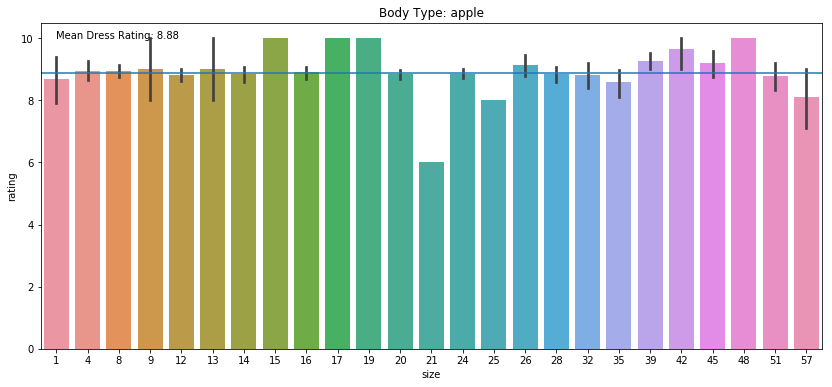

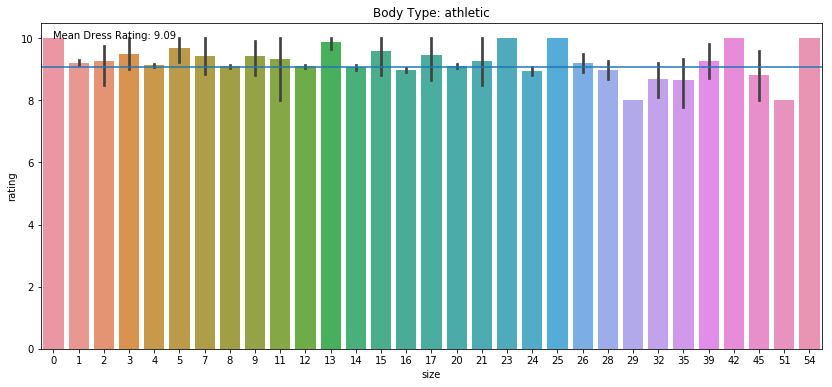

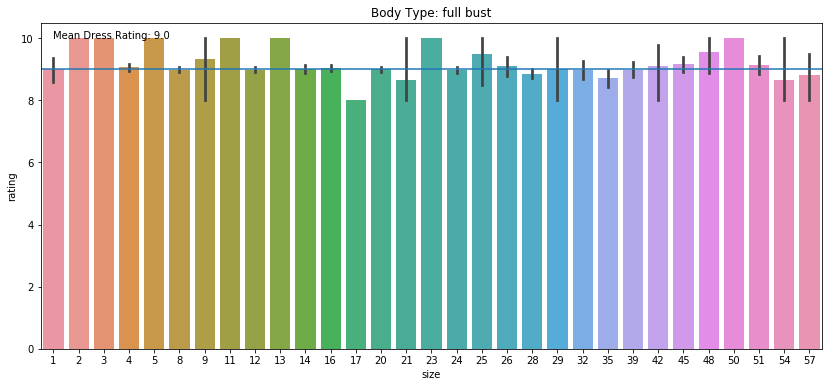

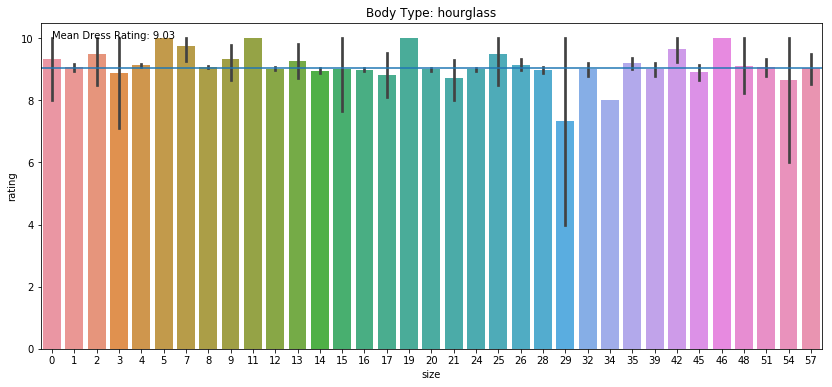

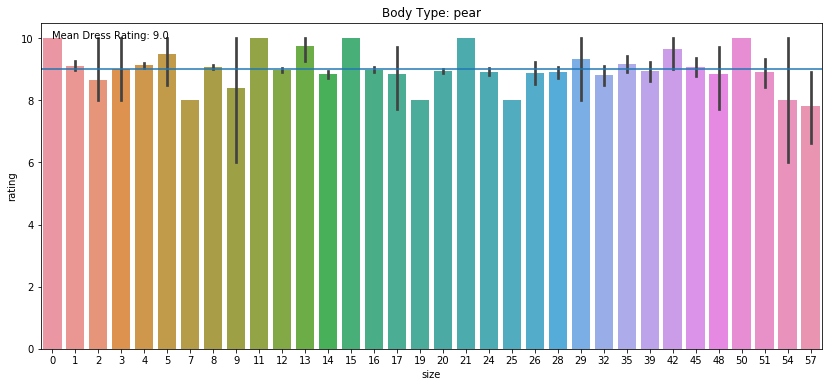

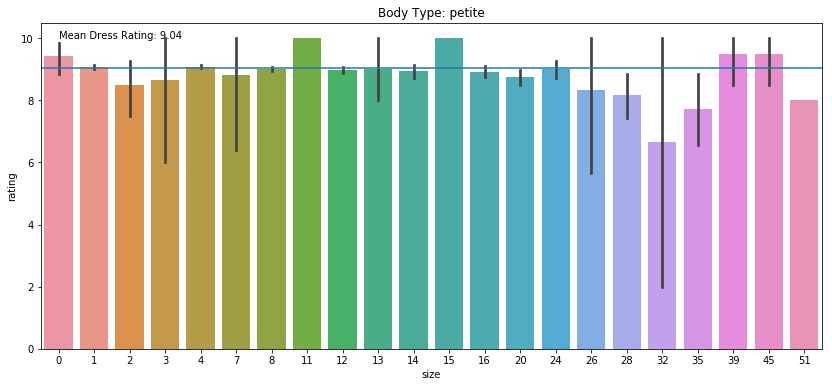

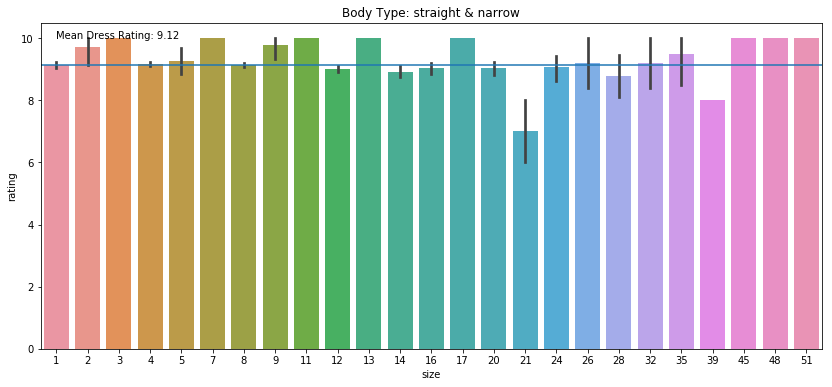

In [8]:
for bodytype in rtr_body_types:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='size', y='rating', data=rtr_data.loc[(rtr_data.body_type==bodytype)&(rtr_data.category=='dress')])
    plt.title('Body Type: '+bodytype)
    mean = rtr_data.loc[(rtr_data.body_type==bodytype)&(rtr_data.category=='dress')].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,10))
    plt.axhline(y=mean)
    plt.show()

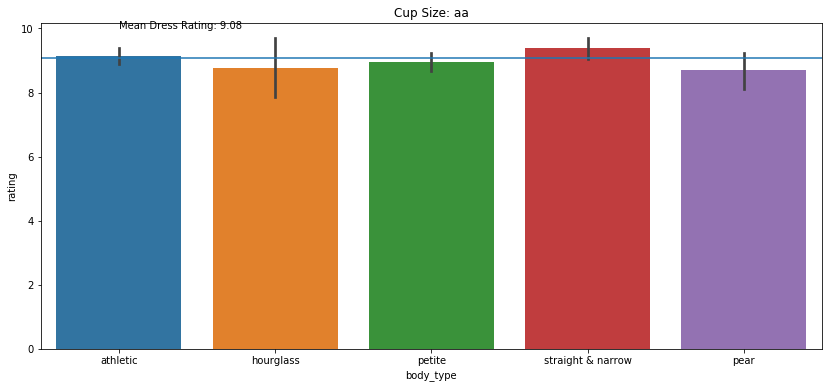

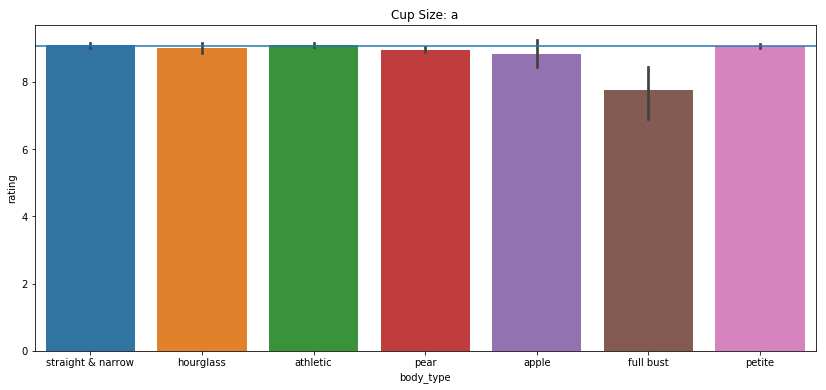

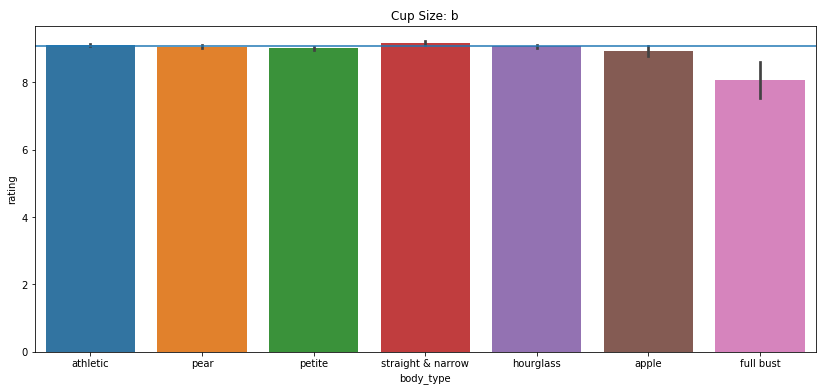

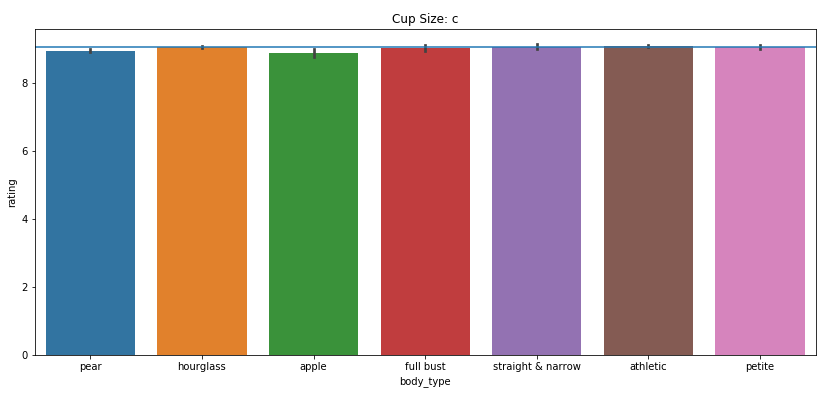

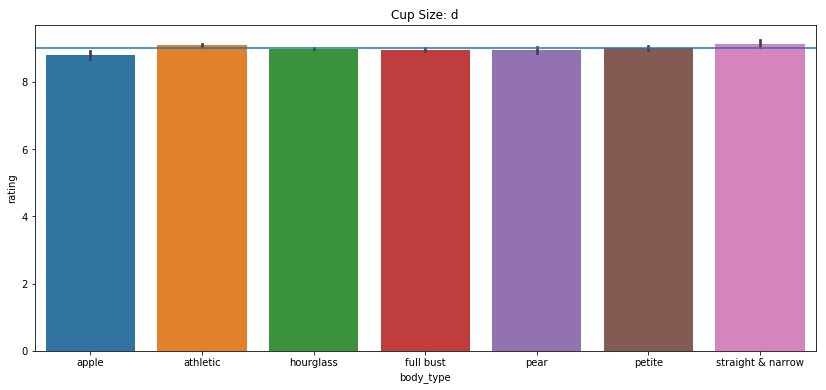

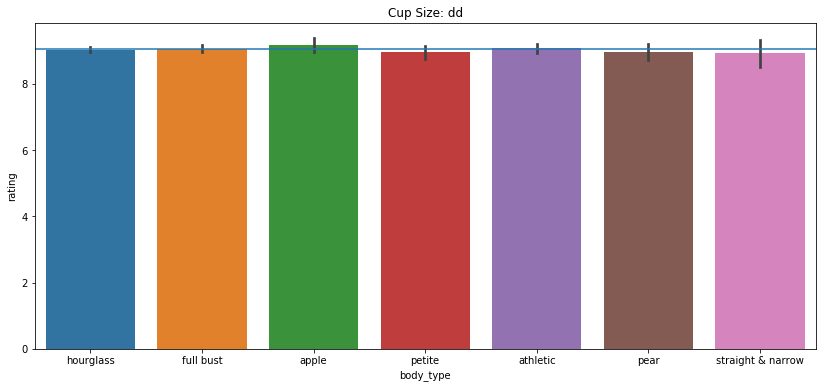

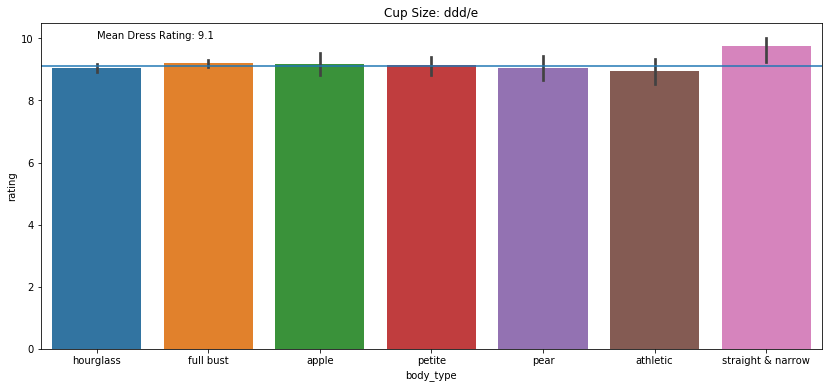

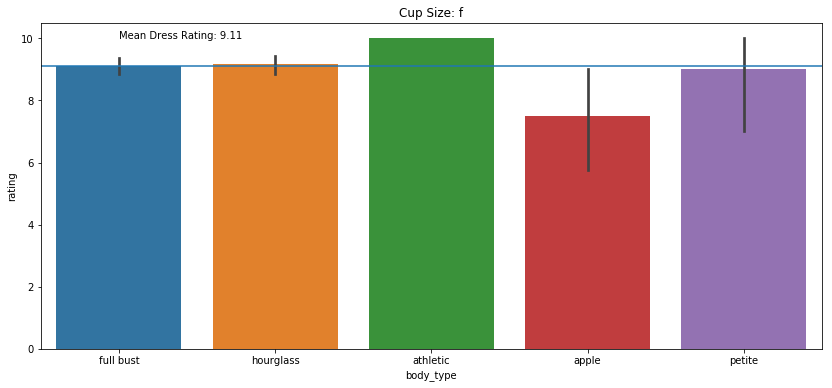

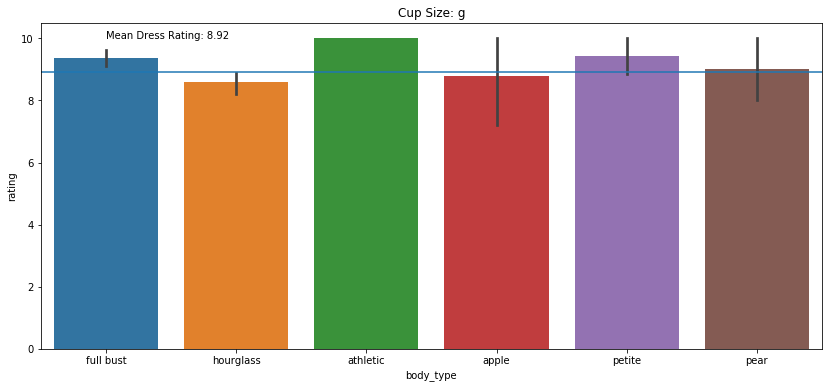

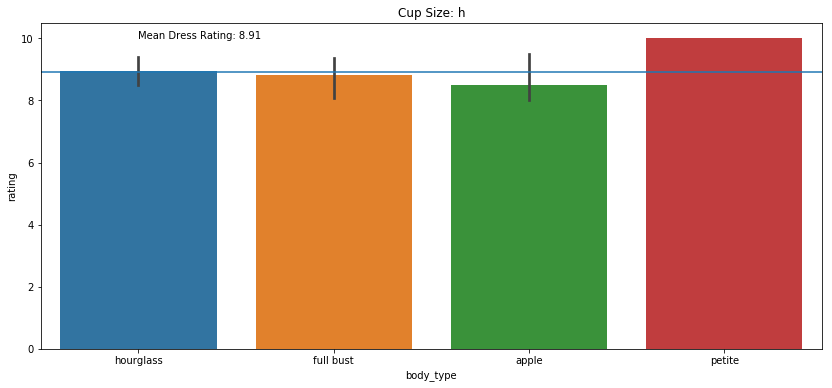

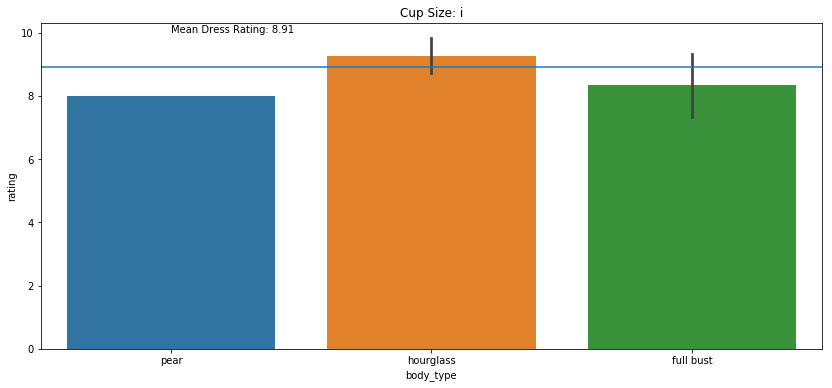

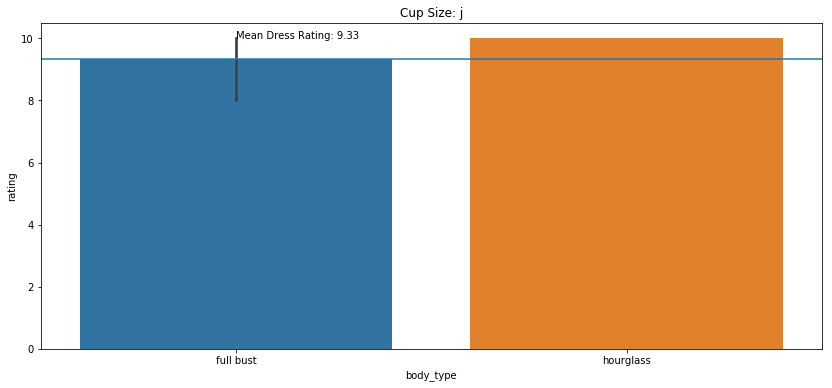

In [9]:
for cup in cup_sizes:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='body_type', y='rating', data=rtr_data.loc[(rtr_data.cup_size==cup)&(rtr_data.category=='dress')])
    plt.title('Cup Size: '+cup)
    mean = rtr_data.loc[(rtr_data.cup_size==cup)&(rtr_data.category=='dress')].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,10))
    plt.axhline(y=mean)
    plt.show()

So if the user self-described as __full bust__ and had a cup size smaller than a $b$, they seem more likely to rate the dress lower than average. 
In the other direction, if the user self-describes as __straight and narrow__ with a cup size of $ddd$ , they seem more likely to rate the dress higher than average.

Next I want to know:
### Did user's with different body types buy the same dresses? If so, how did ratings change?

In [10]:
print(len(rtr_data.item_id.unique()), len(rtr_data.loc[rtr_data.category=='dress'].item_id.unique()))

5850 2615


So there are 5850 distinct items, 2615 of which are dresses

In [11]:
rtr_data.loc[rtr_data.category=='dress'].item_id.value_counts().head()

126335    2229
174086    1724
136110    1196
172027     984
130259     913
Name: item_id, dtype: int64

In [12]:
top_5_most_reviewed_dresses = list(rtr_data.loc[rtr_data.category=='dress'].item_id.value_counts().head().index)
top_5_most_reviewed_dresses

[126335, 174086, 136110, 172027, 130259]

In [13]:
for dress in top_5_most_reviewed_dresses:
    print(rtr_data.loc[rtr_data.item_id==dress].rating.describe())

count    2229.000000
mean        8.960072
std         1.500665
min         2.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64
count    1724.000000
mean        9.013921
std         1.365283
min         2.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64
count    1196.000000
mean        9.081940
std         1.360522
min         2.000000
25%         8.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64
count    984.000000
mean       8.587398
std        1.683044
min        2.000000
25%        8.000000
50%        8.000000
75%       10.000000
max       10.000000
Name: rating, dtype: float64
count    913.000000
mean       8.768894
std        1.536199
min        2.000000
25%        8.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: rating, dtype: float64


The top 5 most reviewed dresses have pretty high averages. 
Lets see if their ratings are determined by body type.

***
_Aside_:
    What are the other most often reviewed garment types?

In [14]:
top_5_most_reviewed_garments = list(rtr_data.item_id.value_counts().head().index)
top_5_most_reviewed_garments

[126335, 174086, 123793, 132738, 145906]

In [15]:
for garment in top_5_most_reviewed_garments:
    print(rtr_data.loc[rtr_data.item_id==garment].groupby('item_id').first().category)

item_id
126335    dress
Name: category, dtype: object
item_id
174086    dress
Name: category, dtype: object
item_id
123793    gown
Name: category, dtype: object
item_id
132738    gown
Name: category, dtype: object
item_id
145906    gown
Name: category, dtype: object


The other most often reviewed garment types are gowns. 
We could merge this with dress info, but for ease of understanding, we will keep this distinct and focus on garments labelled as dresses.
***

Now, 
### Did user's with different body types buy the same dresses? If so, how did ratings change?

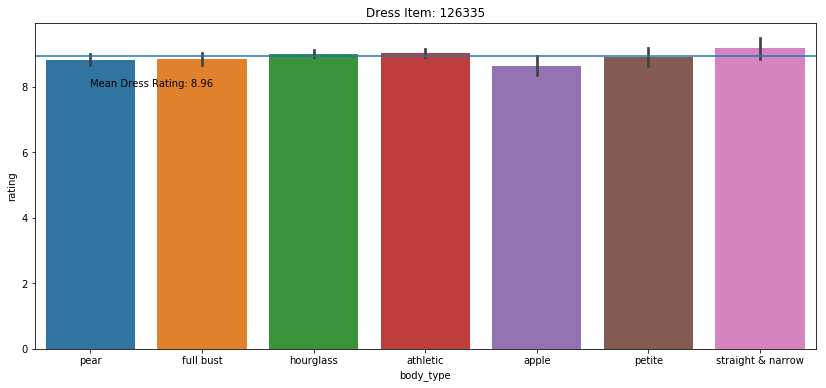

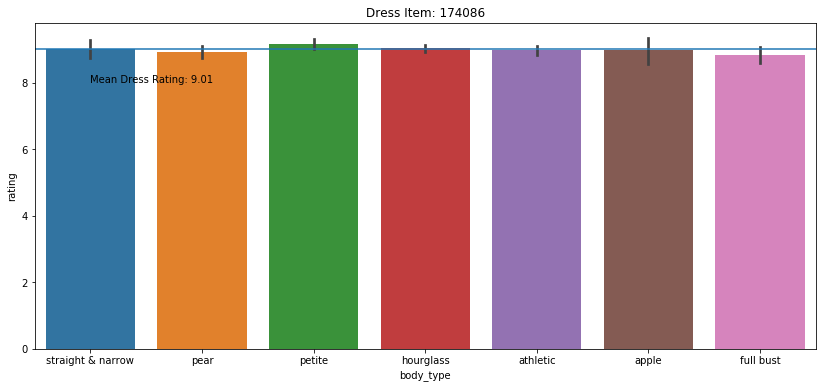

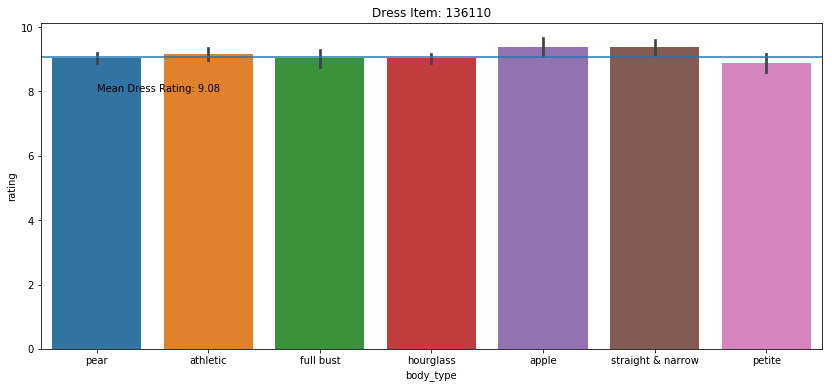

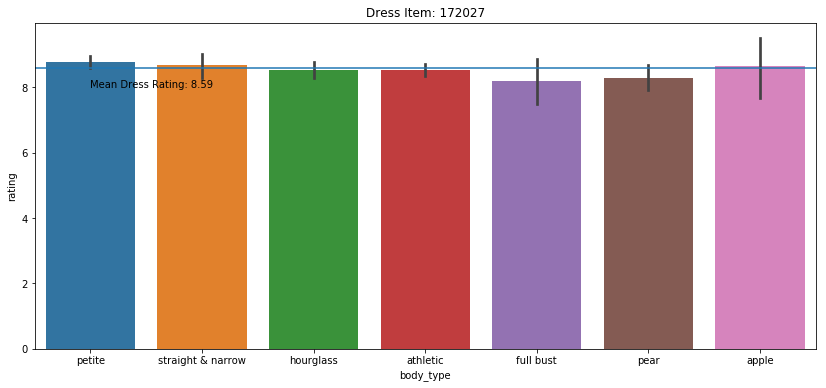

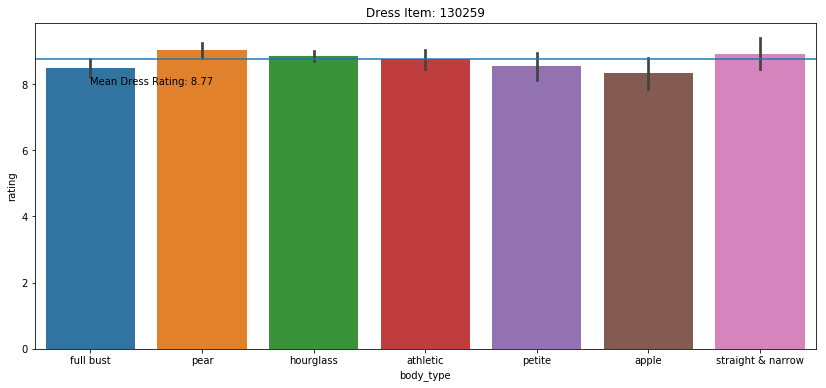

In [16]:
for dress in top_5_most_reviewed_dresses:
    plt.figure(figsize=(14, 6))
    sns.barplot(x='body_type', y='rating', data=rtr_data.loc[(rtr_data.item_id==dress)])
    plt.title('Dress Item: '+str(dress))
    mean = rtr_data.loc[(rtr_data.item_id==dress)].rating.mean()
    plt.annotate('Mean Dress Rating: '+str(round(mean, 2)), (0,8))
    plt.axhline(y=mean)
    plt.show()

It looks ilke there are some differences in the average means given body type depending on the dress. 
If there are enough values in each of these categories, we would like to use a two sample $t$ test to compare the highest and lowest average ratings given body type.

In [ ]:
stats.ttest_ind

In [17]:
for dress in top_5_most_reviewed_dresses:
    for bodytype in rtr_body_types:
        print(f'There are {len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)])} users with {bodytype} body type and who reviewed dress {dress}.')

There are 114 users with apple body type and who reviewed dress 126335.
There are 373 users with athletic body type and who reviewed dress 126335.
There are 292 users with full bust body type and who reviewed dress 126335.
There are 842 users with hourglass body type and who reviewed dress 126335.
There are 329 users with pear body type and who reviewed dress 126335.
There are 126 users with petite body type and who reviewed dress 126335.
There are 78 users with straight & narrow body type and who reviewed dress 126335.
There are 49 users with apple body type and who reviewed dress 174086.
There are 385 users with athletic body type and who reviewed dress 174086.
There are 185 users with full bust body type and who reviewed dress 174086.
There are 484 users with hourglass body type and who reviewed dress 174086.
There are 194 users with pear body type and who reviewed dress 174086.
There are 279 users with petite body type and who reviewed dress 174086.
There are 97 users with straight

Self-described body types of athletic or hourglass consistently have more reviews for each dress. 
Lets see if their means are statistically different from each other. 
First, we must determine if the ratings are normally distributed...

In [18]:
for dress in top_5_most_reviewed_dresses:
    for bodytype in rtr_body_types:
        k2, p = stats.normaltest(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)].rating)
        if p>0.05:
            print(dress, bodytype, 'are normally distributed.')

172027 pear are normally distributed.
130259 straight & narrow are normally distributed.


C:\Users\cliff\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [19]:
def resampling_func(item, bodytype, n, size):
    df = rtr_data.loc[(rtr_data.item_id==item)&(rtr_data.body_type==bodytype)]

    resamples = []
    for i in range(n):
        resamples.append(np.random.choice(df.dropna(axis=0, subset=['rating',]).rating, size=100))
    
    means = [resamples[i].mean() for i in range(n)]
    k2, p = stats.normaltest(means)
    if p<=0.05:
        print('Increase "n" or "size" to get a distribution closer to normal')
        sns.distplot(means)
        plt.show()
        return p
    else:
        return means

Increase "n" or "size" to get a distribution closer to normal


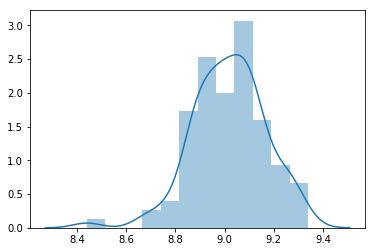

Increase "n" or "size" to get a distribution closer to normal


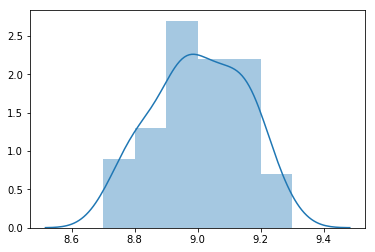

dict_keys([(126335, 'athletic'), (126335, 'hourglass'), (174086, 'athletic'), (174086, 'hourglass'), (136110, 'athletic'), (136110, 'hourglass'), (172027, 'athletic'), (172027, 'hourglass'), (130259, 'athletic'), (130259, 'hourglass')])

In [20]:
new_samples = {}
for dress in top_5_most_reviewed_dresses:
    for bodytype in ['athletic', 'hourglass']:
        new_samples[(dress, bodytype)] = resampling_func(dress, bodytype, 100, 30)

new_samples.keys()

In [21]:
for dress in top_5_most_reviewed_dresses:
    print(dress, stats.ttest_ind(new_samples[(dress, 'athletic')], new_samples[(dress, 'hourglass')], equal_var=False))

126335 Ttest_indResult(statistic=nan, pvalue=nan)
174086 Ttest_indResult(statistic=nan, pvalue=nan)
136110 Ttest_indResult(statistic=6.857070956383813, pvalue=9.436928095344413e-11)
172027 Ttest_indResult(statistic=-0.7656678268713537, pvalue=0.4447921635904156)
130259 Ttest_indResult(statistic=-3.7021167034474485, pvalue=0.00027960993337772445)


C:\Users\cliff\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\cliff\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cliff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\cliff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\cliff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [22]:
It 

NameError: name 'It' is not defined

Not all of the samples have a large $n$. 
In fact, some have a downright small $n$, like:

    *There are 26 users with straight & narrow body type and who reviewed dress 130259.
    *There are 12 users with apple body type and who reviewed dress 172027.
    
We'll run a proportions test on rating higher than 8 instead!

For each sample we'll need to check that $n\cdot p>5$ and $n\cdot (1-p)>5$ for all samples involved.

In [ ]:
for dress in top_5_most_reviewed_dresses:
    for bodytype in rtr_body_types:
        n = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)])
        p = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)&(rtr_data.rating>8)])/n
        if n*p<=5 or n*(1-p)<=5:
            print(f'Users with {bodytype} body type who reviewed dress {dress}: np={n*p}, n(1-p)={n*(1-p)}.')

So each sample is viable to compare with a proportions test!
Let's compare the highest and lowest proportion of higher than 8 average rating for each dress.

In [ ]:
extreme_ratings_proportions = {}
for dress in top_5_most_reviewed_dresses:
    ratings = []
    for bodytype in rtr_body_types:
        n = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)])
        x = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.body_type==bodytype)&(rtr_data.rating>8)])
        p = x/n
        ratings.append({'body_type':bodytype, 'x':x, 'n':n, 'p':p})
    ratings = sorted(ratings, key=lambda rating: rating['p'])
    total_n = len(rtr_data.loc[(rtr_data.item_id==dress)])
    total_p = len(rtr_data.loc[(rtr_data.item_id==dress)&(rtr_data.rating>8)])/total_n 
    extreme_ratings_proportions[dress] = (total_p, ratings[0], ratings[-1])
    
extreme_ratings_proportions

### $H_0$: Given a dress, proportion of reviews>8 for body_type x = proportion of reviews>8 average.

In [ ]:
for dress in top_5_most_reviewed_dresses:
    p = extreme_ratings_proportions[dress][0]
    
    # Binomial test that the least proportions is statiscally lower than the population proportion
    x = extreme_ratings_proportions[dress][1]['x']
    n = extreme_ratings_proportions[dress][1]['n']
    body_type = extreme_ratings_proportions[dress][1]['body_type']
    p_value = stats.binom_test(x=x, n=n, p=p, alternative='less')
    print(f'Binomial test that body type {body_type} rates dress {dress} less than average: {p_value}')
    
    # Binomial test that the least proportions is statiscally lower than the population proportion
    x = extreme_ratings_proportions[dress][2]['x']
    n = extreme_ratings_proportions[dress][2]['n']
    body_type = extreme_ratings_proportions[dress][2]['body_type']
    p_value = stats.binom_test(x=x, n=n, p=p, alternative='greater')
    print(f'Binomial test that body type {body_type} rates dress {dress} greater than average: {p_value}')

### Only have evidence to reject the null for two tests:
    Apple body types' proportion of ratings >8 on dress 126335 is less than average: p=0.014517517633023506
    Petite body types' proportions of ratings >8 on dress 174086 is greater than average: p=0.015179002157341324

## Did a user's body change over time?

In [ ]:
rtr_users = rtr_data.groupby('user_id').count()

changed_users = []
for user in list(rtr_users.loc[rtr_users.review_date>1].index.values):
    total = len(rtr_data.loc[rtr_data.user_id==user])
    same = rtr_data.loc[rtr_data.user_id==user].duplicated(['bust_size', 'size', 'height'], keep=False).sum()
    if total-same>0:
        changed_users.append((user, total-same))

len(changed_users)

***
## How many of each self-described body type are there?

In [ ]:
sns.countplot(data=rtr_data, y='body_type')
plt.show()

Looks like a lot of users self-describe as hourglass. 
We don't have waist or hip measurements in this data, but we do have ```band_size```, ```cup```, and ```weight```... maybe we can see if there is a relationship between these (again self-describd) variables and the ```body_type```.

In [ ]:
for bodytype in rtr_body_types:
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='weight', y='size', hue='cup_size', legend='brief', data=rtr_data.loc[rtr_data.body_type==bodytype].groupby('user_id').first())
    plt.title(bodytype)
    plt.xlim(50,310)
    plt.ylim(-10,60)
    plt.show()

In [ ]:
rtr_data.loc[(rtr_data.category=='dress')&(rtr_data.body_type=='hourglass')].describe()

In [ ]:
rtr_data.loc[(rtr_data.category=='dress')&(rtr_data.body_type=='apple')].describe()

***